In [3]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

import os
import numpy as np
import matplotlib.pyplot as plt

2024-08-12 14:25:22.570569: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1723487122.581254  370253 cuda_dnn.cc:8396] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1723487122.584493  370253 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-12 14:25:22.595087: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-12 14:25:23.252175: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
# Get project files
#wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

#unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [5]:
# 3
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(train_dir, 
                                                           target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                           shuffle=True,
                                                           color_mode='rgb',
                                                           batch_size=128,
                                                           class_mode='binary')
val_data_gen = validation_image_generator.flow_from_directory(validation_dir,
                                                              target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                              shuffle=True,
                                                              color_mode='rgb',
                                                              batch_size=32,
                                                              class_mode='binary')
test_data_gen = test_image_generator.flow_from_directory(test_dir,
                                                         target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                         shuffle=False,
                                                         color_mode='rgb',
                                                         batch_size=50, 
                                                         class_mode='binary',
                                                         classes=['.'])

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


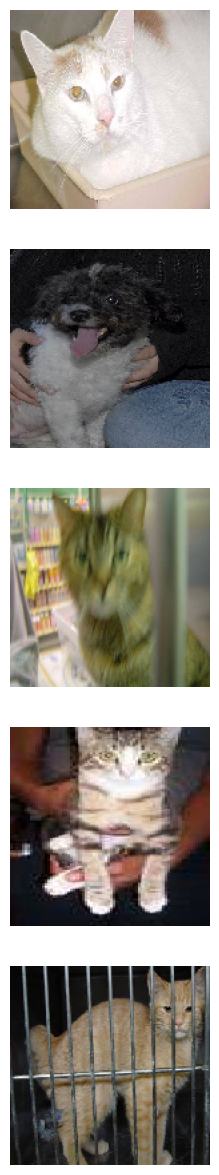

In [6]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [7]:
# 5
train_image_generator = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.3,horizontal_flip=True, 
                                           vertical_flip=True)


Found 2000 images belonging to 2 classes.


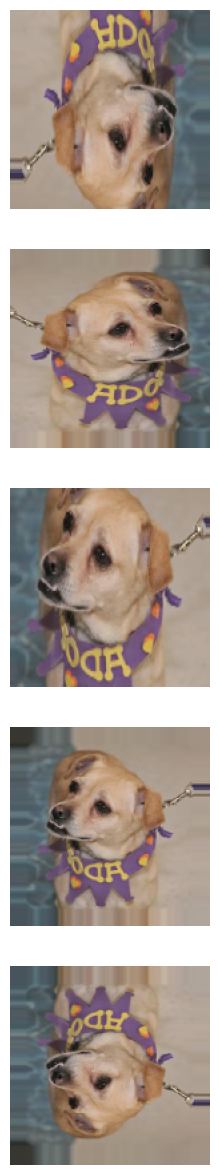

In [8]:
# 6
train_data_gen = train_image_generator.flow_from_directory(directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     shuffle=True,
                                                     color_mode='rgb',
                                                     batch_size=64,
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [9]:
# 7
model = Sequential([Input(shape=(IMG_HEIGHT,IMG_WIDTH,3)),
    Conv2D(16, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(32, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(64, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(128, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.8),
    Dense(1, activation='sigmoid'),
])

model.summary()

model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])


I0000 00:00:1723487125.851228  370253 cuda_executor.cc:795] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1723487125.869487  370253 cuda_executor.cc:795] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1723487125.869529  370253 cuda_executor.cc:795] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1723487125.871891  370253 cuda_executor.cc:795] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1723487125.871926  370253 cuda_executor.cc:795] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:172

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 900,513 (3.44 MB)

 Trainable params: 900,513 (3.44 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# 8
spe = train_data_gen.samples // train_data_gen.batch_size
vs = val_data_gen.samples // val_data_gen.batch_size

history = model.fit(train_data_gen,
          steps_per_epoch = spe,
          epochs = epochs,
          validation_data = val_data_gen,
          validation_steps = vs)

Epoch 1/15


/home/mostafa/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1723487130.586449  370611 service.cc:148] XLA service 0x7fdb3c001ef0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1723487130.586515  370611 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
2024-08-12 14:25:30.625152: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1723487130.821754  370611 cuda_dnn.cc:530] Loaded cuDNN version 8907


 1/31 ━━━━━━━━━━━━━━━━━━━━ 3:13 6s/step - accuracy: 0.4844 - loss: 0.7101

I0000 00:00:1723487134.102816  370611 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


31/31 ━━━━━━━━━━━━━━━━━━━━ 15s 286ms/step - accuracy: 0.4997 - loss: 0.7083 - val_accuracy: 0.4990 - val_loss: 0.6887
Epoch 2/15
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6094 - loss: 0.6775

2024-08-12 14:25:42.731629: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-12 14:25:42.731683: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6094 - loss: 0.6775 - val_accuracy: 0.6250 - val_loss: 0.6707
Epoch 3/15


2024-08-12 14:25:43.089758: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-08-12 14:25:43.089811: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562781257299100171
2024-08-12 14:25:43.089841: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7580319243964875552


31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 184ms/step - accuracy: 0.5539 - loss: 0.6853 - val_accuracy: 0.5958 - val_loss: 0.6741
Epoch 4/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step - accuracy: 0.5312 - loss: 0.6899 - val_accuracy: 0.7500 - val_loss: 0.6325
Epoch 5/15


2024-08-12 14:25:50.272435: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562781257299100171
2024-08-12 14:25:50.272495: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7580319243964875552
2024-08-12 14:25:50.277514: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-08-12 14:25:50.277575: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562781257299100171
2024-08-12 14:25:50.277600: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7580319243964875552


31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 185ms/step - accuracy: 0.5763 - loss: 0.6782 - val_accuracy: 0.5917 - val_loss: 0.6529
Epoch 6/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step - accuracy: 0.6719 - loss: 0.6238 - val_accuracy: 0.6250 - val_loss: 0.5043
Epoch 7/15


2024-08-12 14:25:57.563631: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562781257299100171
2024-08-12 14:25:57.568376: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562781257299100171
2024-08-12 14:25:57.568430: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7580319243964875552


31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 184ms/step - accuracy: 0.5704 - loss: 0.6795 - val_accuracy: 0.6038 - val_loss: 0.6426
Epoch 8/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step - accuracy: 0.6094 - loss: 0.6597 - val_accuracy: 0.1250 - val_loss: 0.8466
Epoch 9/15


2024-08-12 14:26:04.766416: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562781257299100171
2024-08-12 14:26:04.771198: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-08-12 14:26:04.771240: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562781257299100171
2024-08-12 14:26:04.771269: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7580319243964875552


31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 185ms/step - accuracy: 0.5775 - loss: 0.6710 - val_accuracy: 0.6522 - val_loss: 0.6504
Epoch 10/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step - accuracy: 0.5781 - loss: 0.6676 - val_accuracy: 0.8750 - val_loss: 0.5824
Epoch 11/15


2024-08-12 14:26:12.050408: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562781257299100171
2024-08-12 14:26:12.050460: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7580319243964875552


31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 182ms/step - accuracy: 0.6336 - loss: 0.6475 - val_accuracy: 0.6421 - val_loss: 0.6263
Epoch 12/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - accuracy: 0.5625 - loss: 0.6672 - val_accuracy: 0.8750 - val_loss: 0.5812
Epoch 13/15


2024-08-12 14:26:19.167866: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562781257299100171
2024-08-12 14:26:19.167924: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7580319243964875552
2024-08-12 14:26:19.172745: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562781257299100171
2024-08-12 14:26:19.172797: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7580319243964875552


31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 189ms/step - accuracy: 0.6323 - loss: 0.6361 - val_accuracy: 0.6643 - val_loss: 0.6133
Epoch 14/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - accuracy: 0.5938 - loss: 0.6377 - val_accuracy: 0.6250 - val_loss: 0.6179
Epoch 15/15


2024-08-12 14:26:26.488432: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562781257299100171
2024-08-12 14:26:26.488487: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7580319243964875552


31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 194ms/step - accuracy: 0.6553 - loss: 0.6361 - val_accuracy: 0.7026 - val_loss: 0.5850


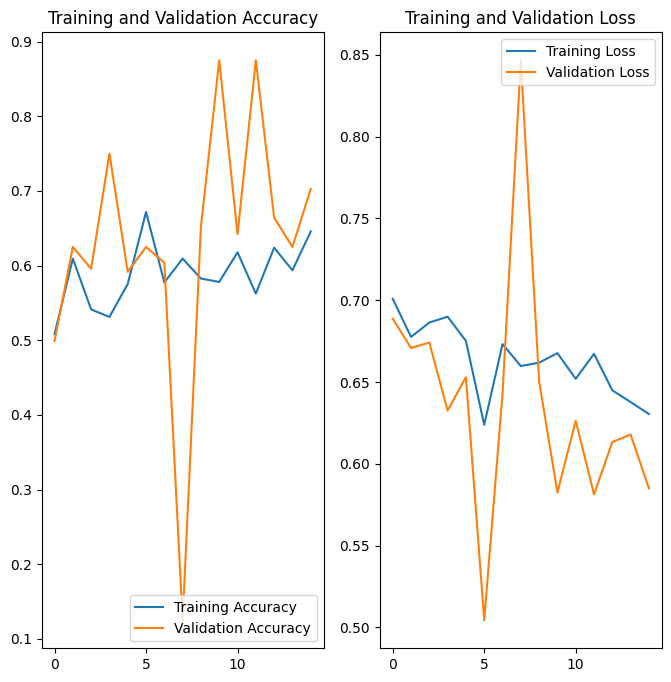

In [14]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


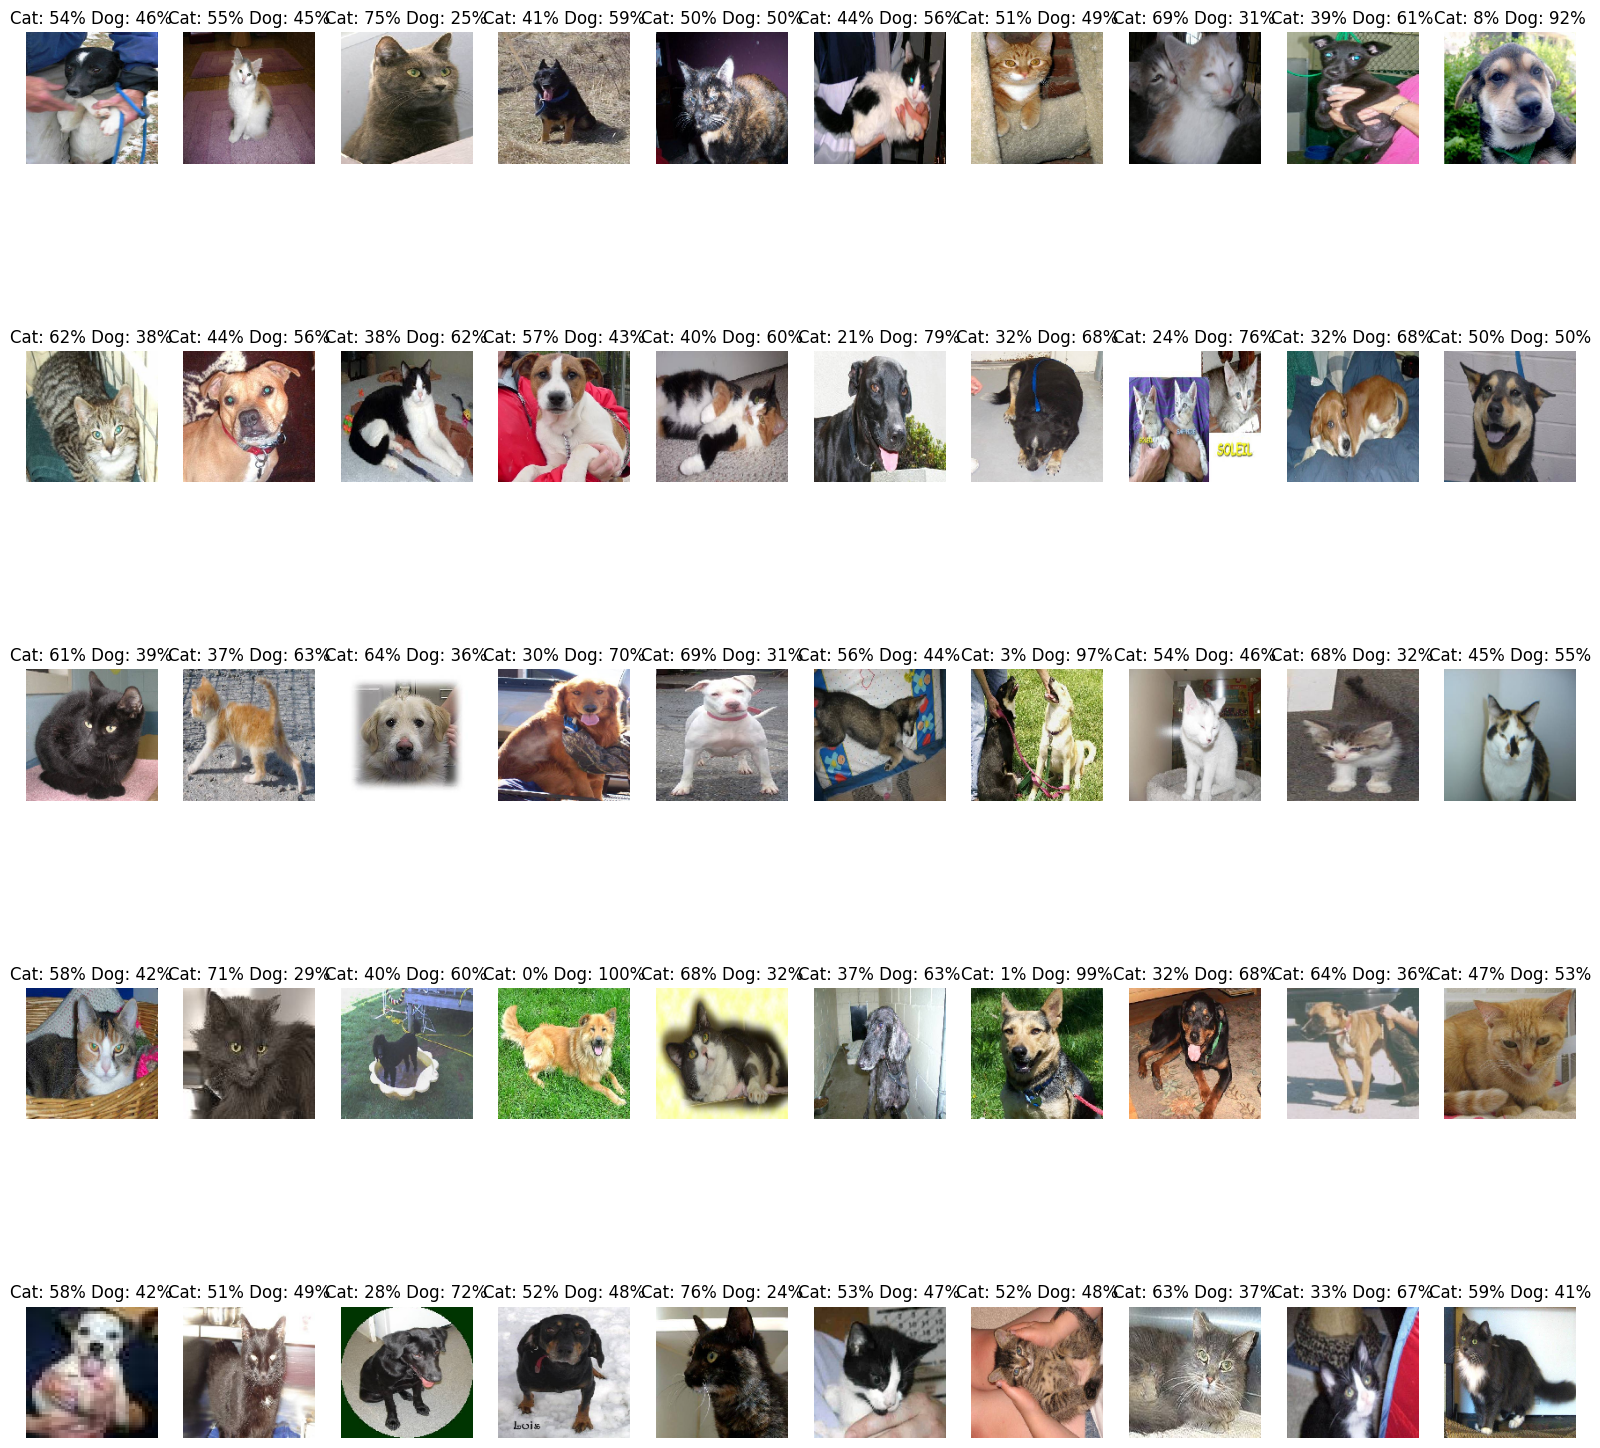

In [15]:
# 10
probabilities = model.predict(test_data_gen)

test_images = next(test_data_gen)[0]
plt.figure(figsize=(20, 20))
for i in range(len(test_images)):
    dog_prob = round(probabilities[i].item() * 100)
    cat_prob = 100 - dog_prob
    plt.subplot(5, 10, i+1)
    plt.imshow(test_images[i])
    plt.title(f"Cat: {cat_prob}% Dog: {dog_prob}%")
    plt.axis('off')
plt.show()

In [16]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability.item()) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 68.0% of the images of cats and dogs.
You passed the challenge!
